# Plot flow cytometry of expression dynamics of mCherry after supernatant transfer

# Introduction

## Imports

In [1]:
import sys
import os
import time

import numpy as np
import scipy
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

## Set output parameters

In [2]:
# Set pandas display options
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Set plot display options
FONTSIZE = 8  # universal fontsize
params = {
    'font.size': FONTSIZE,
    'axes.titlesize': FONTSIZE,
    'axes.labelsize': FONTSIZE,
    'legend.fontsize': FONTSIZE,
    'xtick.labelsize': FONTSIZE,
    'ytick.labelsize': FONTSIZE,
    'font.family': "Helvetica",
    'mathtext.fontset': 'custom',
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 300
   }
mpl.rcParams.update(params)
sns.set_style("ticks", {'axes.grid' : False})

# Set plot output options
output_dir = "outs/flow_mCherry_dynamics"
output_suffix = ""
output_formats = [".png", ".pdf"]

mpl.rc('savefig', dpi=300)

# Define convenience function for saving figures

savefig = True
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0.1}

def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    if savefig:
        for output_format in output_formats:
            fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

In [3]:
# Report plot parameters
sns.plotting_context()

{'font.size': 8.0,
 'axes.labelsize': 8.0,
 'axes.titlesize': 8.0,
 'xtick.labelsize': 8.0,
 'ytick.labelsize': 8.0,
 'legend.fontsize': 8.0,
 'legend.title_fontsize': None,
 'axes.linewidth': 0.8,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1.5,
 'lines.markersize': 6.0,
 'patch.linewidth': 1.0,
 'xtick.major.width': 0.8,
 'ytick.major.width': 0.8,
 'xtick.minor.width': 0.6,
 'ytick.minor.width': 0.6,
 'xtick.major.size': 3.5,
 'ytick.major.size': 3.5,
 'xtick.minor.size': 2.0,
 'ytick.minor.size': 2.0}

# Load data

## Summary of replicates

In [4]:
infile = "../preprocessed_data/flow_data/flow_mCherry_dynamics_summary.csv"

summary_raw = pd.read_csv(infile, index_col="id")

# Set time as numeric
summary_raw["Time"] = pd.to_numeric(summary_raw["Time"])

print(summary_raw.shape)
summary_raw.head()

(63, 6)


,Well,Condition,Replicate,Time,Singlets,mCherry
id,,,,,,
1,A1,exporter,1,0,10824,2
2,A2,exporter,2,0,10816,3
3,A3,exporter,3,0,10446,2
4,A4,no_exporter,1,0,10814,2
5,A5,no_exporter,2,0,10427,3


## Full distribution of events from individual replicates

In [5]:
# Set input files
samples_infiles = {"Exporter_0h": "../preprocessed_data/flow_data/flow_mCherry_dynamics_exporter_0h.csv",
                   "Exporter_3h": "../preprocessed_data/flow_data/flow_mCherry_dynamics_exporter_3h.csv",
                   "Exporter_6h": "../preprocessed_data/flow_data/flow_mCherry_dynamics_exporter_6h.csv",
                   "Exporter_12h": "../preprocessed_data/flow_data/flow_mCherry_dynamics_exporter_12h.csv",
                   "Exporter_24h": "../preprocessed_data/flow_data/flow_mCherry_dynamics_exporter_24h.csv",
                   "Exporter_32h": "../preprocessed_data/flow_data/flow_mCherry_dynamics_exporter_32h.csv",
                   "Exporter_48h": "../preprocessed_data/flow_data/flow_mCherry_dynamics_exporter_48h.csv",}

In [6]:
# Load events and concatenate into one dataframe

dfs_temp = []

for sample, infile in samples_infiles.items():
    
    df_temp = pd.read_csv(infile, index_col=None)
    df_temp["Sample"] = sample
    
    print("Sample:", sample, "-- Loaded", df_temp.shape[0], "events")
    
    dfs_temp.append(df_temp)

df_raw = pd.concat(dfs_temp)

print(df_raw.shape)
df_raw.head()

Sample: Exporter_0h -- Loaded 10824 events
Sample: Exporter_3h -- Loaded 11377 events
Sample: Exporter_6h -- Loaded 10940 events
Sample: Exporter_12h -- Loaded 9806 events
Sample: Exporter_24h -- Loaded 10062 events
Sample: Exporter_32h -- Loaded 11409 events
Sample: Exporter_48h -- Loaded 10027 events
(74445, 7)


,FSC-A,FSC-H,FSC-Width,SSC-A,SSC-H,mCherry-A,Sample
0,167972,221525,776.469,254550,169722.0,197.534,Exporter_0h
1,401243,280900,1462.720,341658,202105.0,524.243,Exporter_0h
2,199384,196776,1037.610,280839,172322.0,434.668,Exporter_0h
3,335471,249386,1377.480,278132,172454.0,121.847,Exporter_0h
4,336835,276320,1248.300,272032,172012.0,192.129,Exporter_0h


# Preprocess data

In [7]:
# Calculate percent mCherry+
summary_raw["% mCherry+"] = 100 * summary_raw["mCherry"] / summary_raw["Singlets"]

In [8]:
# Summarize biological replicates
summary = summary_raw.groupby(["Condition", "Time"]).mean()
summary["% mCherry+ STD"] = summary_raw.groupby(["Condition", "Time"]).std()["% mCherry+"]

summary = summary.reset_index()

print(summary.shape)
summary.head()

(21, 7)


,Condition,Time,Replicate,Singlets,mCherry,% mCherry+,% mCherry+ STD
0,direct_RNA,0,2.0,10382.000000,2.333333,0.022521,0.011225
1,direct_RNA,3,2.0,10994.666667,887.333333,8.069080,0.131586
2,direct_RNA,6,2.0,10821.333333,4004.333333,37.008493,2.060987
3,direct_RNA,12,2.0,10943.666667,7769.000000,70.987153,7.648444
4,direct_RNA,24,2.0,11212.666667,10769.000000,96.043353,0.226736


In [9]:
# Log transform
df_raw["log10 mCherry-A"] = np.log10(df_raw["mCherry-A"])

/scratch/resources/anaconda3/envs/RNA_export_magic/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Plot dynamics of mCherry expression as summary of replicates

In [10]:
palette = ["#756bb1", "#44adbf", "#969696"]

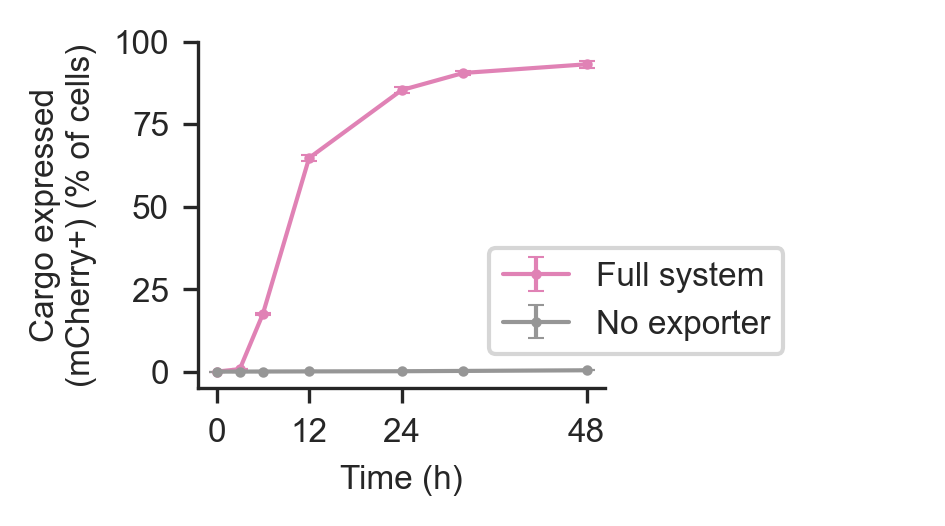

In [11]:
# Plot with error bars

fig, ax = plt.subplots(1, 1, figsize=(1.75,1.5))

data_subset = summary.loc[summary["Condition"] == "exporter"]
ax.errorbar(data=data_subset,
            x="Time",
            y="% mCherry+",
            yerr="% mCherry+ STD",
            color="#e082b5",
            marker=".",
            markersize=3,
            capsize=2,
            capthick=0.5,
            lw=1,
            label="Full system")
            

data_subset = summary.loc[summary["Condition"] == "no_exporter"]
ax.errorbar(data=data_subset,
            x="Time",
            y="% mCherry+",
            yerr="% mCherry+ STD",
            color=palette[2],
            marker=".",
            markersize=3,
            capsize=2,
            capthick=0.5,
            lw=1,
            label="No exporter")


ax.set_ylim(-5, 100)

ax.set_xlabel("Time (h)")
ax.set_ylabel("Cargo expressed\n(mCherry+) (% of cells)")

ax.set_xticks([0, 12, 24, 48])

fig.legend(loc="center left", bbox_to_anchor=(0.9, 0.5))

sns.despine()

save_figure(fig, "lineplot_errorbar_mCh")

# Plot dynamics of mCherry expression as full distribution of mCherry intensity across time

In [12]:
# Get magma as a hex color map
cmap = mpl.cm.get_cmap('magma', 9)    # PiYG

for i in range(cmap.N):
    rgba = cmap(i)
    # rgb2hex accepts rgb or rgba
    print(mpl.colors.rgb2hex(rgba))

#000004
#1d1147
#51127c
#832681
#b73779
#e75263
#fc8961
#fec488
#fcfdbf


In [13]:
samples = ['Exporter_0h',
           'Exporter_3h',
           'Exporter_6h',
           'Exporter_12h',
           'Exporter_24h',
           'Exporter_32h',
           'Exporter_48h']

colors = ["#000004", "#1d1147", "#51127c", "#832681", "#b73779", "#e75263", "#fc8961", "#fec488", "#fcfdbf"]

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


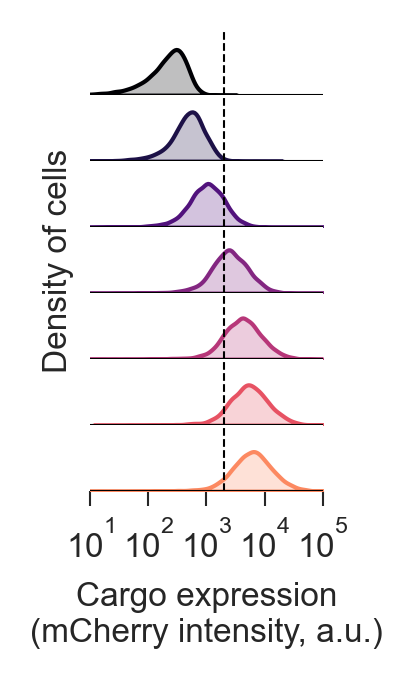

In [14]:

fig, axes = plt.subplots(7, 1, figsize=(1,2))

for ax in axes:
    ax.set_xlim(1,5)
    ax.set_ylim(0,2)
    ax.set_xlabel("")
    ax.set_ylabel("")
    
for ax, sample, color in zip(axes, samples, colors):

    data_subset = df_raw.loc[df_raw["Sample"] == sample]
    x = data_subset["log10 mCherry-A"]
    sns.kdeplot(ax=ax,
                data=data_subset,
                x=x,
                color=color,
                fill=True,
                lw=1)

    
for ax in axes:
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axvline(np.log10(2e3), color="k", lw=0.5, ls="--")
    # ax.axvline(1, color="k", lw=1)
    ax.axhline(0, color="k", lw=0.5)
    sns.despine(left=True, bottom=True)

axes[-1].set_xticks([1, 2, 3, 4, 5])
axes[-1].set_xticklabels([r"$10^1$", r"$10^2$", r"$10^3$", r"$10^4$", r"$10^5$"])
ax.xaxis.set_tick_params(width=0.5)

axes[-1].set_xlabel("Cargo expression\n(mCherry intensity, a.u.)")
axes[3].set_ylabel("Density of cells")

fig.subplots_adjust(hspace=0)

save_figure(fig, "ridgeplot_mCh")

## Report statistics

In [15]:
summary

,Condition,Time,Replicate,Singlets,mCherry,% mCherry+,% mCherry+ STD
0,direct_RNA,0,2.0,10382.000000,2.333333,0.022521,0.011225
1,direct_RNA,3,2.0,10994.666667,887.333333,8.069080,0.131586
2,direct_RNA,6,2.0,10821.333333,4004.333333,37.008493,2.060987
3,direct_RNA,12,2.0,10943.666667,7769.000000,70.987153,7.648444
4,direct_RNA,24,2.0,11212.666667,10769.000000,96.043353,0.226736
5,direct_RNA,32,2.0,11596.666667,11314.666667,97.566500,0.383711
6,direct_RNA,48,2.0,10922.333333,10749.000000,98.413039,0.214672
7,exporter,0,2.0,10695.333333,2.333333,0.021787,0.005164
8,exporter,3,2.0,11453.000000,85.666667,0.747785,0.062009
9,exporter,6,2.0,10980.333333,1919.333333,17.478499,0.385861
